In [1]:
! pip install torchmetrics lightning -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.0/660.0 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import os
import torch
import random
import torchvision
from torch import nn
import lightning.pytorch as pl
import torchvision.transforms as T
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.datasets import MNIST, CIFAR10
from lightning.pytorch.loggers import TensorBoardLogger
from torch.utils.data import TensorDataset, DataLoader, random_split
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor

In [2]:
def prepare_data(data):

  if data == 'mnist':
    # transforms for images
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,)),
                                  transforms.Resize((32, 32), antialias=True)
                                  ])
    # prepare transforms standard to MNIST
    train = MNIST('./data', train=True, download=True, transform=transform)
    test = MNIST('./data', train=False, download=True, transform=transform)

  else:
    transform = transforms.Compose(
                        [transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        transforms.Resize((32, 32), antialias=True)])
    train = CIFAR10('./data', train=True, download=True, transform=transform)
    test = CIFAR10(root='./data', train=False, download=True, transform=transform)

  return train, test

In [3]:
mnist_train, mnist_test = prepare_data('mnist')
#cifar_train, cifar_test = prepare_data('cifar')
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 9912422/9912422 [00:00<00:00, 59559277.83it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 59322083.17it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21017496.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7647743.38it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
train_loader, test_loader = DataLoader(mnist_train, batch_size=512, num_workers=8), DataLoader(mnist_test, batch_size=512, num_workers=8)

In [3]:
# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

In [4]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, 2 * z_dim)

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3, img_dim=64):
        super().__init__()
        self.in_planes = 512
        self.img_dim = img_dim
        self.nc = nc
        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=img_dim/32)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), self.nc, self.img_dim, self.img_dim)
        return x

In [29]:
class VAE(pl.LightningModule):
    def __init__(self, num_classes=10, latent_dim=128, img_dim=32, num_channels=3):
        super().__init__()

        self.img_dim = img_dim
        self.num_channels = num_channels
        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = ResNet18Enc(z_dim=latent_dim, nc=num_channels+1)
        self.decoder = ResNet18Dec(z_dim=latent_dim, nc=num_channels, img_dim=img_dim)
        self.embedding = nn.Embedding(num_classes, img_dim*img_dim)
        
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        scheduler = OneCycleLR(
            optimizer,
            max_lr=1e-1,
            steps_per_epoch=49,
            epochs=self.trainer.max_epochs,
            pct_start=30/self.trainer.max_epochs,
            div_factor=100,
            three_phase=True,
            final_div_factor=10,
            anneal_strategy='cos'
        )
        return {'optimizer': optimizer, 
                'lr_scheduler': {'scheduler': scheduler, 'interval': 'step'}}

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def model_step(self, batch):
        x, y = batch
        y_embed = self.embedding(y)
        y_embed = y_embed.view(x.shape[0], 1, self.img_dim, self.img_dim)
        x_add = torch.cat([x, y_embed], dim=1)

        # encode x to get the mu and variance parameters
        mu, log_var = self.encoder(x_add)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()
        return(recon_loss, kl, elbo)

    def training_step(self, batch, batch_idx):
        recon_loss, kl, elbo = self.model_step(batch)
        self.log('elbo_train', elbo, prog_bar=True, on_epoch=True, on_step=True, logger=True)
        self.log('kl_train', kl.mean(), prog_bar=True, on_epoch=True, on_step=True, logger=True)
        self.log('recon_loss_train', recon_loss.mean(), prog_bar=True, on_epoch=True, on_step=True, logger=True)
        return elbo

    def validation_step(self, batch, batch_idx):
        recon_loss, kl, elbo = self.model_step(batch)
        self.log('elbo_val', elbo, prog_bar=True, on_epoch=True, on_step=True, logger=True)
        self.log('kl_val', kl.mean(), prog_bar=True, on_epoch=True, on_step=True, logger=True)
        self.log('recon_loss_val', recon_loss.mean(), prog_bar=True, on_epoch=True, on_step=True, logger=True)
        return elbo

In [ ]:
vae = VAE(num_channels=1)
trainer = pl.Trainer(
                     log_every_n_steps=1,
                     check_val_every_n_epoch=1,
                     enable_model_summary=True,
                     max_epochs=100,
                     accelerator='auto',
                     devices='auto',
                     strategy='auto',
                     logger=[TensorBoardLogger("logs/", name="VAE-MNIST")],
                     callbacks=[LearningRateMonitor(logging_interval="step")]
                     )
trainer.fit(vae, train_loader, test_loader)

In [7]:
def get_labels(y, correct_class=True):
    if correct_class:
        return(y)
    else:
        incorrect_labels = []
        for eachy in y:
            p = eachy.item()
            if p > 4:
                p -= random.choice(list(range(1, 4)))
            else:
                p += random.choice(list(range(1, 4)))
            incorrect_labels.append(p)
        return(torch.tensor(incorrect_labels))

In [26]:
def computeVae(x, y, model, correct_class=True):

    model.eval()
    y = get_labels(y, correct_class=correct_class)
    y = y.cpu()
    
    y_embed = vae.embedding(y)
    y_embed = y_embed.view(-1, 1, x.shape[2], x.shape[3])
    x_add = torch.cat([x, y_embed], dim=1)
    mu, log_var = model.encoder(x_add)

    std = torch.exp(log_var/2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()

    x_hat = model.decoder(z)
    return(x_hat, y)

In [19]:
def make_plot(orig_images, gen_images_c, gen_images_i, incorrect_y, nrow=5):

  close_figures()

  fig = plt.figure(figsize=(10, 12))

  fig.add_subplot(3, 1, 1)
  plt.imshow(t2img(torchvision.utils.make_grid(unorm(orig_images), nrow=nrow)), interpolation='nearest')
  plt.axis('off')
  plt.title("Original Images")

  fig.add_subplot(3, 1, 2)
  plt.imshow(t2img(torchvision.utils.make_grid(unorm(gen_images_c), nrow=nrow)), interpolation='nearest')
  plt.axis('off')
  plt.title('Correct')

  fig.add_subplot(3, 1, 3)
  plt.imshow(t2img(torchvision.utils.make_grid(unorm(gen_images_i), nrow=nrow)), interpolation='nearest')
  plt.axis('off')
  plt.title('Incorrect')

  fig, axes = plt.subplots(5, 5, figsize=(2, 2))

  for i,ax in enumerate(axes.flat):
      ax.imshow(digits.images[incorrect_y[i]])
      ax.axis('off')

In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits()

In [19]:
test_imgs = next(iter(test_loader))
test_labs = test_imgs[1][:25]
test_imgs = test_imgs[0][:25]

In [25]:
test_hat_correct, _ = computeVae(test_imgs.cuda(), test_labs.cuda(), vae, correct_class=True)
test_hat_incorrect, y_incorrect = computeVae(test_imgs.cuda(), test_labs.cuda(), vae, correct_class=False)

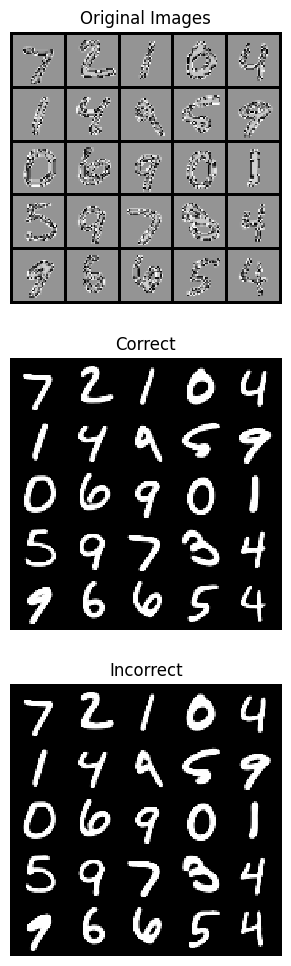

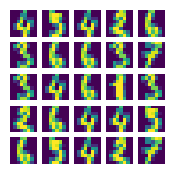

In [37]:
make_plot(test_imgs, test_hat_correct, test_hat_incorrect, y_incorrect, nrow=5)

In [11]:
def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()


In [12]:
cifar_train, cifar_test = prepare_data('cifar10')
train_loader, test_loader = DataLoader(cifar_train, batch_size=1024, num_workers=10), DataLoader(cifar_test, batch_size=1024, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
vae = VAE(num_channels=3)
trainer = pl.Trainer(
                     log_every_n_steps=1,
                     check_val_every_n_epoch=1,
                     enable_model_summary=True,
                     max_epochs=100,
                     accelerator='auto',
                     devices='auto',
                     strategy='auto',
                     logger=[TensorBoardLogger("logs/", name="VAE-CIFAR10")], 
                     callbacks=[LearningRateMonitor(logging_interval="step")]
                     )
trainer.fit(vae, train_loader, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | encoder   | ResNet18Enc | 11.3 M
1 | decoder   | ResNet18Dec | 12.6 M
2 | embedding | Embedding   | 10.2 K
------------------------------------------
23.9 M    Trainable params
0         Non-trainable params
23.9 M    Total params
95.684    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 49: 100%|██████████| 49/49 [00:16<00:00,  3.04it/s, v_num=2, elbo_train_step=1.57e+3, kl_train_step=36.60, recon_loss_train_step=-1.54e+3, elbo_val_step=1.65e+3, kl_val_step=36.50, recon_loss_val_step=-1.61e+3, elbo_val_epoch=1.59e+3, kl_val_epoch=36.50, recon_loss_val_epoch=-1.55e+3, elbo_train_epoch=1.59e+3, kl_train_epoch=36.50, recon_loss_train_epoch=-1.56e+3]

In [16]:
test_imgs = next(iter(test_loader))
test_labs = test_imgs[1][-25:]
test_imgs = test_imgs[0][-25:]

In [27]:
test_hat_correct, _ = computeVae(test_imgs.cpu(), test_labs.cpu(), vae.cpu(), correct_class=True)
test_hat_incorrect, y_incorrect = computeVae(test_imgs.cpu(), test_labs.cpu(), vae.cpu(), correct_class=False)

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(1, 3, 1, 1)
        self.std = torch.tensor(std).view(1, 3, 1, 1)

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (B, C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        return tensor * self.std + self.mean

unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

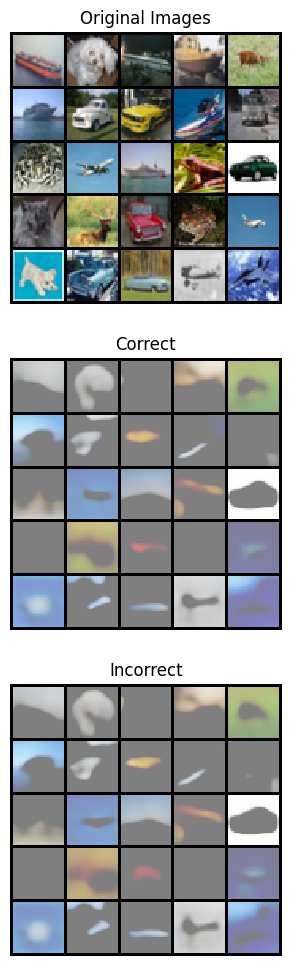

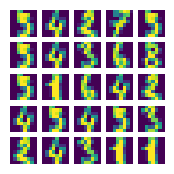

In [ ]:
make_plot(test_imgs, test_hat_correct.cpu(), test_hat_incorrect.cpu(), y_incorrect.cpu(), nrow=5)

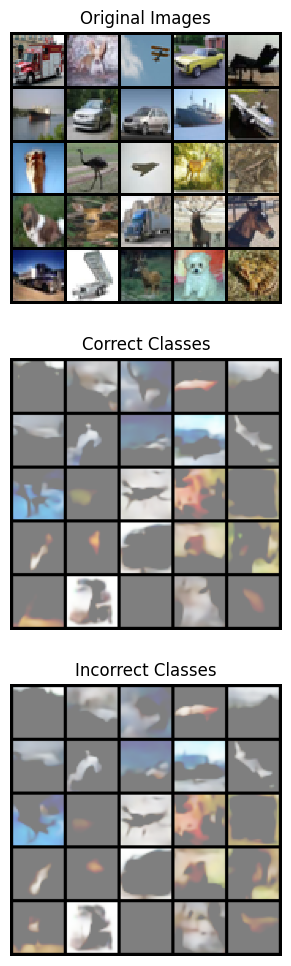

In [ ]:
make_plot(test_imgs, test_hat_correct, test_hat_incorrect, y_incorrect, nrow=5)

In [ ]:
from torchsummary import summary

summary(vae.decoder(), (1, 256))